In [1]:
import pickle
import pathlib
from collections import Counter
import matplotlib.pyplot as plt
from file_parser import FileParser

In [2]:
files = list(pathlib.Path("data/txt/").glob("*.txt"))
file_names = [f.name for f in files]
makams = [f.split("--")[0] for f in file_names]
counter = Counter(makams)

In [3]:
common_makams = counter.most_common(12)
common_makam_names = [t[0] for t in common_makams]
print(common_makams)

[('hicaz', 157), ('nihavent', 130), ('ussak', 118), ('rast', 108), ('huzzam', 96), ('segah', 92), ('huseyni', 92), ('mahur', 88), ('hicazkar', 79), ('kurdilihicazkar', 70), ('muhayyer', 67), ('saba', 66)]


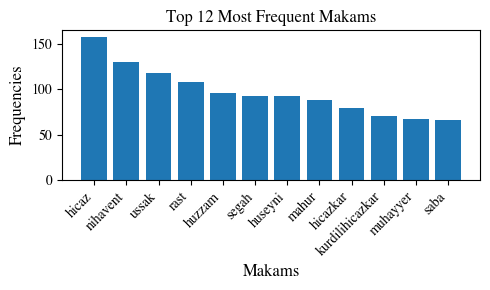

In [4]:
plt.figure(figsize=(5, 3))
plt.bar(common_makam_names, [t[1] for t in common_makams])
plt.title("Top 12 Most Frequent Makams", fontname="Times", fontsize=12)
plt.xlabel("Makams", fontname="Times", fontsize=12)
plt.ylabel("Frequencies", fontname="Times", fontsize=12)
plt.xticks(rotation=45, ha="right", fontname="Times", fontsize=10)
plt.yticks(fontname="Times", fontsize=10)
plt.tight_layout()
# plt.savefig("makam_freq.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [5]:
common_makam_file_names = [
    f for f in file_names if f.split("--")[0] in common_makam_names]

In [6]:
makam_files = {m: [] for m in common_makam_names}

In [7]:
for f in common_makam_file_names:
    makam_files[f.split("--")[0]].append(f)

In [8]:
makam_files.keys()

dict_keys(['hicaz', 'nihavent', 'ussak', 'rast', 'huzzam', 'segah', 'huseyni', 'mahur', 'hicazkar', 'kurdilihicazkar', 'muhayyer', 'saba'])

In [9]:
fp = FileParser()
parsed_files = {}
pc_dict = {
    "PAD": 0, "Es": 1,
    "G": 2, "A": 3, "B": 4, "C": 5, "D": 6, "E": 7, "F": 8
}
acc_dict = {
    "PAD": 0, None: 1,
    "#1": 2, "#2": 3, "#3": 4, "#4": 5, "#5": 6, "#6": 7, "#7": 8, "#8": 9
}
oct_dict = {
    "PAD": 0, None: 1,
    3: 2, 4: 3, 5: 4, 6: 5, 7: 6
}
dur_counter = Counter()
meas_dict = {"PAD": 0, "start": 1, "middle": 2, "end": 3}

for makam, files_list in makam_files.items():
    parsed_files[makam] = []
    for file_path in files_list:
        note_list = fp.parse_file(f"data/txt/{file_path}")
        for (pc, acc, oct, dur, meas) in note_list:  # PC, Acc, Oct, Dur, MeasureBoundry
            if pc not in pc_dict:
                print(pc, "not in pc dict!")
            if acc not in acc_dict:
                print(acc, "not in acc dict!")
            if oct not in oct_dict:
                print(oct, "not in octave dict!")
            if meas not in meas_dict:
                print(meas, "not in meas dict!")
            dur_counter[dur] += 1
        parsed_files[makam].append({"f_name": file_path, "notes": note_list})

In [10]:
common_durs = [d[0]
               for d in sorted(dur_counter.most_common(32), key=lambda x: x[0])]
dur_dict = {"PAD": 0}
dur_dict_idx = 1
for c in common_durs:
    dur_dict[c] = dur_dict_idx
    dur_dict_idx += 1

def quantize_duration(d):
    return min(common_durs, key=lambda x: abs(x - d))

In [11]:
covered = sum(dur_counter[d] for d in common_durs if d in dur_counter)
total = sum(dur_counter.values())

print(f"Coverage: {covered / total:.2%}")

Coverage: 95.63%


In [11]:
makam_dict = {}
makam_idx = 0
for makam in makam_files:
    makam_dict[makam] = makam_idx
    makam_idx += 1

In [12]:
vocab = {
    "pc": pc_dict,
    "acc": acc_dict,
    "oct": oct_dict,
    "dur": dur_dict,
    "meas": meas_dict,
    "makam": makam_dict
}

In [13]:
quantize_duration(0.008935)

0.008929

In [14]:
dataset = {}
for makam, pieces in parsed_files.items():
    dataset[makam] = []
    for piece in pieces:
        piece_num = []
        for note in piece["notes"]:  # PC, Acc, Oct, Dur, MeasureBoundry
            piece_num.append((
                vocab["pc"][note[0]],
                vocab["acc"][note[1]],
                vocab["oct"][note[2]],
                vocab["dur"][quantize_duration(note[3])],
                vocab["meas"][note[4]]
            ))
        dataset[makam].append({"f_name": piece["f_name"], "notes": piece_num})

In [15]:
with open("vocab.pkl", "wb") as out_file:
    pickle.dump(vocab, out_file)

with open("dataset.pkl", "wb") as out_file:
    pickle.dump(dataset, out_file)